### Instaling libs

In [1]:
# ! pip install --upgrade rfpimp
# ! pip install --upgrade scikit-learn
# ! pip install --upgrade pyarrow
# ! pip install --upgrade yellowbrick
# ! pip install --upgrade pandas

### Column description

| Variável 	| Descrição 	|
|:-:	|:-	|
| PassangerID 	| ID de identificação do passageiro(a) 	|
| Survived 	| se o passageiro(a) sobreviveu (0 = não, 1 = sim) 	|
| Pclass 	| classe do passageiro:<br>     * **1 = primeira**,<br>     * **2 = segunda**,<br>     * **3 = terceira** 	|
| name 	| nome do passageiro(a) 	|
| sex 	| sexo do passageiro(a) 	|
| age 	| idade do passageiro(a) 	|
| Sibsp 	| número de irmão(ãs)/esposo(a) à bordo 	|
| Parch 	| número de pais/filhos(as) à bordo 	|
| Ticket 	| número da passagem 	|
| Fare 	| preço da passagem 	|
| Cabin 	| cabine 	|
| Embarked 	| local que o passageiro(a) embarcou:<br>     * **C = Cherboug**,<br>     * **Q = Queenstown**,<br>     * **S = Southamption** 	|
| WikiId 	| ID de identificação do passageiro(a) segundo Wikipedia 	|
| Name_wiki 	| nome do passageiro(a) 	|
| Age_wiki 	| idade do passageiro(a) 	|
| Hometown 	| cidade de nascimento do passageiro(a) 	|
| Boarded 	| cidade de embarque 	|
| Destination 	| destino da viagem 	|
| Lifeboat 	| identificação do bote salva-vidas 	|
| Body 	| número de identificação do corpo 	|


<font color='red'>**IMPORTANT**</font>

The new features (the ones after 'Embarked') are very similar to the original ones but they are more up-to-date and have much fewer missing values. Therefore, users can decide on the preferred features themselves.

### Importing Libs

In [2]:
# data visualization
import rfpimp

%matplotlib inline

import seaborn as sns

import matplotlib.pyplot as plt

from seaborn import (
    jointplot,
    pairplot,
    boxplot,
    heatmap
)
from yellowbrick.features import (
    RFECV,
    Rank2D, 
    RadViz,
    ParallelCoordinates,
    JointPlotVisualizer
)

# data manipulation
import numpy as np
import pandas as pd
from pandas.plotting import(
    radviz
)
import janitor as jn
from ydata_profiling import ProfileReport

# missing values
import missingno as msno

from sklearn.impute import (
    SimpleImputer
)

# machine learning models
from sklearn import (
    tree,
    impute,
    ensemble,
    linear_model,
    preprocessing,
    model_selection,
    feature_selection,
)

from sklearn.feature_selection import (
    RFE
)

from sklearn.dummy import (
    DummyClassifier
)

from sklearn.model_selection import (
    train_test_split
)

from sklearn.experimental import (
    enable_iterative_imputer
)

from sklearn.linear_model import (
    LogisticRegression
)

from sklearn.tree import (
    DecisionTreeClassifier
)

from sklearn.neighbors import (
    KNeighborsClassifier
)

from sklearn.naive_bayes import (
    GaussianNB
)

from sklearn.svm import (
    SVC
)

from sklearn.ensemble import (
    RandomForestClassifier
)

import xgboost

# data model metrics
from sklearn.metrics import (
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score
)

from yellowbrick.classifier import (
    ConfusionMatrix
)

from yellowbrick.model_selection import (
    LearningCurve
)

# data prep-model
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    learning_curve
)

# model deploy
import pickle

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Reading the Titanin Dataset

In [3]:
df = pd.read_csv("titanic_dataset.csv", index_col=0)
df.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,WikiId,Name_wiki,Age_wiki,Hometown,Boarded,Destination,Lifeboat,Body,Class
PassengerId,,,,,,,,,,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,691.0,"Braund, Mr. Owen Harris",22.0,"Bridgerule, Devon, England",Southampton,"Qu'Appelle Valley, Saskatchewan, Canada",NaN,NaN,3.0
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,90.0,"Cumings, Mrs. Florence Briggs (née Thayer)",35.0,"New York, New York, US",Cherbourg,"New York, New York, US",4,NaN,1.0
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,865.0,"Heikkinen, Miss Laina",26.0,"Jyväskylä, Finland",Southampton,New York City,14?,NaN,3.0
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,127.0,"Futrelle, Mrs. Lily May (née Peel)",35.0,"Scituate, Massachusetts, US",Southampton,"Scituate, Massachusetts, US",D,NaN,1.0
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,627.0,"Allen, Mr. William Henry",35.0,"Birmingham, West Midlands, England",Southampton,New York City,NaN,NaN,3.0


### Deleting _Class_ feature at the end
We are deleting because is the same as _pclass_ (same result, same data)

In [4]:
df = df.drop('Class', axis = 'columns')
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,WikiId,Name_wiki,Age_wiki,Hometown,Boarded,Destination,Lifeboat,Body
PassengerId,,,,,,,,,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,691.0,"Braund, Mr. Owen Harris",22.0,"Bridgerule, Devon, England",Southampton,"Qu'Appelle Valley, Saskatchewan, Canada",NaN,NaN
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,90.0,"Cumings, Mrs. Florence Briggs (née Thayer)",35.0,"New York, New York, US",Cherbourg,"New York, New York, US",4,NaN
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,865.0,"Heikkinen, Miss Laina",26.0,"Jyväskylä, Finland",Southampton,New York City,14?,NaN
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,127.0,"Futrelle, Mrs. Lily May (née Peel)",35.0,"Scituate, Massachusetts, US",Southampton,"Scituate, Massachusetts, US",D,NaN
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,627.0,"Allen, Mr. William Henry",35.0,"Birmingham, West Midlands, England",Southampton,New York City,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,1227.0,"Spector, Mr. Woolf",23.0,"London, England",Southampton,New York City,NaN,NaN
1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,229.0,"and maid, Doña Fermina Oliva y Ocana",39.0,"Madrid, Spain",Cherbourg,"New York, New York, US",8,NaN
1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,1169.0,"Sæther, Mr. Simon Sivertsen",43.0,"Skaun, Sør-Trøndelag, Norway",Southampton,US,NaN,32MB


### Converting DataFrame Column Names to Lowercase snakecase

In [5]:
df.columns = (df.columns
                .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                .str.lower()
             )

df.dtypes

survived       float64
pclass           int64
name            object
sex             object
age            float64
sib_sp           int64
parch            int64
ticket          object
fare           float64
cabin           object
embarked        object
wiki_id        float64
name_wiki       object
age_wiki       float64
hometown        object
boarded         object
destination     object
lifeboat        object
body            object
dtype: object

### Data Engineering
We can use pandas to generate new attributes. Sometimes, we can receive these transformations from the Engineering team, but other times, we need to create these visions ourselves.

#### Aggregate
We can aggregate cabin data, class, ticket price, among others, with age (average, mode, maximum, minimum, ...). For this, we will use .groupby() method from pandas.

In [6]:
df_agg_cabin = df.drop(columns = ['name',
'ticket',
'sex',
#'cabin',
'embarked',
'name_wiki',
'hometown',
'boarded',
'destination',
'lifeboat',
'body'])

orig_df = df

In [7]:
# cabin feature
agg = (
    df_agg_cabin.groupby("cabin")
    .agg("min,max,mean,sum".split(","))
    .reset_index()
)

agg.columns = [
    "_".join(c).strip("_")
    for c in agg.columns.values
]

agg_df = df_agg_cabin.merge(agg, on = "cabin")

agg_df

,survived,pclass,age,sib_sp,parch,fare,cabin,wiki_id,age_wiki,survived_min,...,fare_mean,fare_sum,wiki_id_min,wiki_id_max,wiki_id_mean,wiki_id_sum,age_wiki_min,age_wiki_max,age_wiki_mean,age_wiki_sum
0,1.0,1,38.0,1,0,71.2833,C85,90.0,35.0,1.0,...,71.2833,142.5666,89.0,90.0,89.5,179.0,35.0,39.0,37.0,74.0
1,1.0,1,35.0,1,0,53.1000,C123,127.0,35.0,0.0,...,53.1000,106.2000,126.0,127.0,126.5,253.0,35.0,37.0,36.0,72.0
2,0.0,1,54.0,0,0,51.8625,E46,200.0,54.0,0.0,...,51.8625,103.7250,158.0,200.0,179.0,358.0,44.0,54.0,49.0,98.0
3,1.0,3,4.0,1,1,16.7000,G6,1193.0,4.0,0.0,...,14.2050,71.0250,1192.0,1239.0,1211.2,6056.0,1.0,29.0,12.0,60.0
4,1.0,1,58.0,0,0,26.5500,C103,35.0,61.0,1.0,...,26.5500,26.5500,35.0,35.0,35.0,35.0,61.0,61.0,61.0,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,NaN,1,43.0,1,0,27.7208,D40,122.0,43.0,NaN,...,27.7208,27.7208,122.0,122.0,122.0,122.0,43.0,43.0,43.0,43.0
291,NaN,2,20.0,0,0,13.8625,D38,218.0,20.0,NaN,...,13.8625,13.8625,218.0,218.0,218.0,218.0,20.0,20.0,20.0,20.0
292,NaN,1,50.0,1,1,211.5000,C80,316.0,50.0,NaN,...,211.5000,423.0000,316.0,318.0,317.0,634.0,50.0,50.0,50.0,100.0
293,NaN,1,37.0,1,0,90.0000,C78,206.0,37.0,0.0,...,81.9375,327.7500,205.0,208.0,206.5,826.0,30.0,44.0,36.0,144.0


In [8]:
# getting the feature types
df.dtypes

survived       float64
pclass           int64
name            object
sex             object
age            float64
sib_sp           int64
parch            int64
ticket          object
fare           float64
cabin           object
embarked        object
wiki_id        float64
name_wiki       object
age_wiki       float64
hometown        object
boarded         object
destination     object
lifeboat        object
body            object
dtype: object

# parei aqui pg.88
## aqui
### aqui

In [9]:
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "name_wiki",
            "wiki_id",
            "age_wiki",
            "ticket",
            "destination",
            "body",
            "cabin",
            "hometown",
            "lifeboat",
            "boarded"
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sib_sp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()
    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(orig_df)
std_cols = "pclass,age,sib_sp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be 

In [10]:
agg_df = agg_df.drop(columns = ['cabin'])

agg_df.dtypes

survived         float64
pclass             int64
age              float64
sib_sp             int64
parch              int64
fare             float64
wiki_id          float64
age_wiki         float64
survived_min     float64
survived_max     float64
survived_mean    float64
survived_sum     float64
pclass_min         int64
pclass_max         int64
pclass_mean      float64
pclass_sum         int64
age_min          float64
age_max          float64
age_mean         float64
age_sum          float64
sib_sp_min         int64
sib_sp_max         int64
sib_sp_mean      float64
sib_sp_sum         int64
parch_min          int64
parch_max          int64
parch_mean       float64
parch_sum          int64
fare_min         float64
fare_max         float64
fare_mean        float64
fare_sum         float64
wiki_id_min      float64
wiki_id_max      float64
wiki_id_mean     float64
wiki_id_sum      float64
age_wiki_min     float64
age_wiki_max     float64
age_wiki_mean    float64
age_wiki_sum     float64


In [11]:
limit = 0.95
corr = agg_df.corr()
mask = np.triu(
    np.ones(corr.shape), k=1
).astype(bool)
corr_no_diag = corr.where(mask)
coll = [
    c
    for c in corr_no_diag.columns
    if any(abs(corr_no_diag[c]) > limit)
]
coll

['age_wiki',
 'pclass_min',
 'pclass_max',
 'pclass_mean',
 'sib_sp_mean',
 'parch_mean',
 'fare_mean',
 'wiki_id_min',
 'wiki_id_max',
 'wiki_id_mean',
 'age_wiki_min',
 'age_wiki_mean']

In [12]:
X_train.isnull().sum()

pclass        0
age           0
sib_sp        0
parch         0
fare          0
sex_male      0
embarked_Q    0
embarked_S    0
dtype: int64

In [13]:
y_train.isnull().sum()

292

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be 

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:42

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:42

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:42

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:42

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:42

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:42

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:42

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:42

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:42

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:42

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:42

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:42

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:42

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:42

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:42

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:429: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/rfpimp.py:42

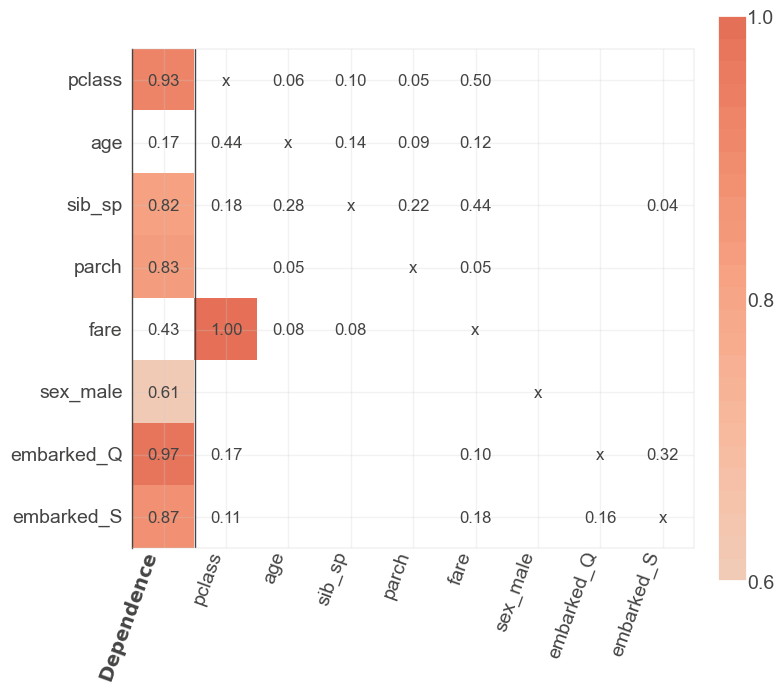

In [14]:
rfpimp.plot_dependence_heatmap(
    rfpimp.feature_dependence_matrix(X_train),
    value_fontsize=12,
    label_fontsize=14,
    figsize=(8, 8)
)
fig = plt.gcf()

In [15]:
# dropping columns taht do not add value
df_prep = df.drop(columns = ['name',
                             'name_wiki',
                             'wiki_id',
                             'hometown',
                             'destination',
                             'ticket',
                             'lifeboat',
                             'body',
                             'cabin',
                             'boarded',
                             'age'])

# using get_dummies function to convert object to int
df_prep = pd.get_dummies(df_prep)

# dropping redundant features
df_prep = df_prep.drop(columns = ['sex_male'])

#remove rows with any values that are not finite (NaN or infite)
df_prep = df_prep[np.isfinite(df_prep).all(1)]

# first, we need to create a series of the target feature
y = df_prep.survived

# then, we create a DataFrame with the attributes
X = df_prep.drop(columns = ['survived'])

# using the scikit-learn to split 30% to test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_i

Text(0.5, 1.0, 'Regression Coefficients Progression for Lasso Paths')

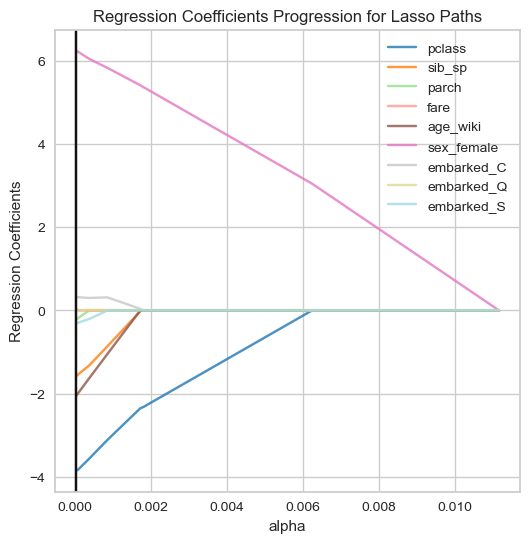

In [16]:
model = linear_model.LassoLarsCV(
    cv = 10, max_n_alphas = 10
).fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(6, 6))

cm = iter(
    plt.get_cmap("tab20")(
        np.linspace(0, 1, X.shape[1])
    )
)

for i in range(X.shape[1]):
    c = next(cm)
    ax.plot(
        model.alphas_,
        model.coef_path_.T[:, i],
        c = c,
        alpha = 0.8,
        label = X.columns[i],
    )
ax.axvline(
    model.alpha_,
    linestyle = "-",
    c = "k",
    label = "alphaCV",
)

plt.ylabel("Regression Coefficients")
ax.legend(X.columns, bbox_to_anchor=(1, 1))
plt.xlabel("alpha")
plt.title(
    "Regression Coefficients Progression for Lasso Paths"
)

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be 

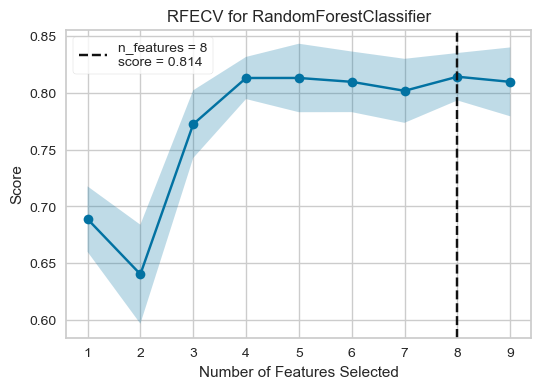

<AxesSubplot:title={'center':'RFECV for RandomForestClassifier'}, xlabel='Number of Features Selected', ylabel='Score'>

In [17]:
fig, ax = plt.subplots(figsize=(6, 4))
rfe = RFECV(
    ensemble.RandomForestClassifier(
        n_estimators = 100
    ),
    cv = 5,
)

rfe.fit(X, y)

rfe.rfe_estimator_.ranking_

rfe.rfe_estimator_.n_features_

rfe.rfe_estimator_.support_

rfe.poof()

In [18]:
model = ensemble.RandomForestClassifier(
    n_estimators=100
)
rfe = RFE(model)
rfe.fit(X, y)
X.columns[rfe.support_]

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be 

Index(['pclass', 'fare', 'age_wiki', 'sex_female'], dtype='object')

/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Users/dellacorte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be 

<AxesSubplot:ylabel='feature'>

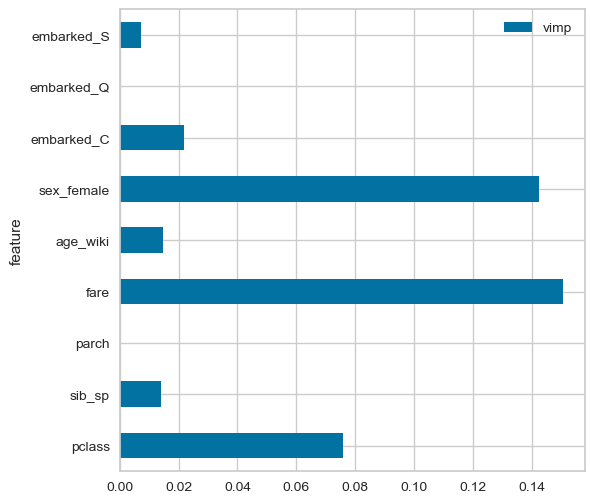

In [19]:
mic = feature_selection.mutual_info_classif(
    X, y
)
fig, ax = plt.subplots(figsize=(6, 6))
(
    pd.DataFrame(
        {"feature": X.columns, "vimp": mic}
    )
    .set_index("feature")
    .plot.barh(ax=ax)
)